# Implementación del simulador paralelo del modelo basicprobabilistic

### El modelo basicprobabilistic se representa como:

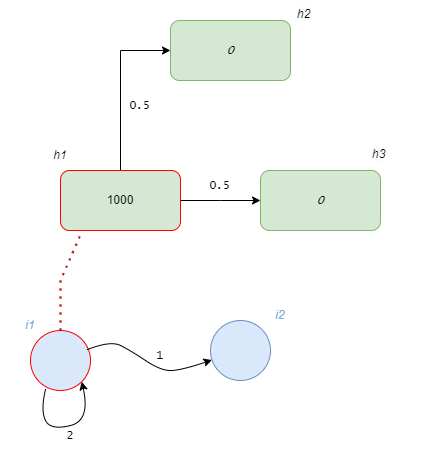

In [2]:
import math
import random
from numba import cuda,jit,njit,config,numba
import numpy as np
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32
import time
import matplotlib.pyplot as plt   
import sys
import os
sys.path.append("/home/servelgar/tfg-cuda/vm/examples")
sys.path.append("/home/servelgar/tfg-cuda/vm/src")
sys.path.append("/home/servelgar/tfg-cuda/vm/tests")
print(sys.path)
from basicprobabilistic import basicprobabilistic

/home/servelgar/.local/lib/python3.9/site-packages/numba/cuda/random.py:45: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(forceobj=_forceobj, looplift=_looplift)
/home/servelgar/.local/lib/python3.9/site-packages/numba/cuda/random.py:71: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(forceobj=_forceobj, looplift=_looplift)
/home/servelgar/.local/lib/pyt

['/home/servelgar/tfg-cuda/src', '/usr/lib64/python39.zip', '/usr/lib64/python3.9', '/usr/lib64/python3.9/lib-dynload', '', '/home/servelgar/.local/lib/python3.9/site-packages', '/usr/local/lib64/python3.9/site-packages', '/usr/local/lib/python3.9/site-packages', '/usr/lib64/python3.9/site-packages', '/usr/lib/python3.9/site-packages', '/home/servelgar/tfg-cuda/vm/examples', '/home/servelgar/tfg-cuda/vm/src', '/home/servelgar/tfg-cuda/vm/tests']


In [3]:
@cuda.jit
def kernel_computeN(array_sims,p,rng_state):
    startx, starty = cuda.grid(2)
    stridex, stridey = cuda.gridsize(2)
    
    cdf = cuda.local.array(shape=2, dtype=np.float64)
    cdf[0] = p
    cdf[1] = p + (1-p)
    index = 0
       
    for i in range(startx, array_sims.shape[0], stridex):
        for j in range(starty, array_sims.shape[1], stridey):
            idx = i * stridey + j
            rng = xoroshiro128p_uniform_float32(rng_state,idx)
            while (rng > cdf[index]):
                index = 1
            array_sims[i, j] = index
            
    
@cuda.jit
def s_reduce_sum(A,C):
    fila = cuda.grid(1)
    if fila < A.shape[0]:
        fila_sum = 0
        for j in range(A.shape[1]):
            fila_sum += A[fila,j]
        C[fila,0] = fila_sum
        C[fila,1] = A.shape[1] - fila_sum

In [4]:
def solucion_basicprobabilistic_sims(array_sims_final):
    tam = array_sims_final.shape[0]
    s = f"basicprobabilistic: {tam} simulaciones\n"
    s += f"nº virus: {n}\n"
    s += "----------------------------------------\n"
    if (tam <= 10):
        for i in range(array_sims_final.shape[0]):
            s += f"Simulación: {i+1}\n"
            s += "HOST 1 | HOST 2 | HOST 3\n"
            (host2,host3) = (array_sims_final[i,0], array_sims_final[i,1])
            s += f"0 | {host2} | {host3}\n"
            s += "++++++++++++++++++++++++++++++++++\n"
    else:
        tam = 5
        for i in range(tam):
            s += f"Simulación: {i+1}\n"
            s += "HOST 1 | HOST 2 | HOST 3\n"
            (host2,host3) = (array_sims_final[i,0], array_sims_final[i,1])
            s += f"0 | {host2} | {host3}\n"
            s += "++++++++++++++++++++++++++++++++++\n"
        for i in range(tam,0,-1):
            if i == tam:
                s += ".\n"
                s += ".\n"
                s += ".\n"
            s += f"Simulación: {array_sims_final.shape[0]-i + 1}\n"
            (host2,host3) = (array_sims_final[i,0], array_sims_final[i,1])
            s += f"0 | {host2} | {host3}\n"
            s += "++++++++++++++++++++++++++++++++++\n"
    return s

In [16]:
@njit
def probabilistic_acum(input_matrix):
    array_media = np.zeros((n_sim,2), dtype = np.float64)
    
    for j in range(input_matrix.shape[1]):
        tmp = 0
        for i in range(input_matrix.shape[0]-1):
            tmp += input_matrix[i][j]
            media = tmp / ((i+1)*n)
            array_media[i][j] = media
    
    return array_media

def solucion_basicprobabilistic_medias(array_media):
    tam = array_media.shape[0]
    s = f"basicprobabilistic: {tam} simulaciones\n"
    s += "probabilidad acumulada entre simulaciones\n"
    s += "probabilidad teórica: \n"
    s += f"host2: {p*100} % | host3: {(1-p)*100} %\n"
    s += "----------------------------------------\n"
    if(tam <= 10):
        for i in range(array_media.shape[0]):
            s += f"Simulación: {i+1}\n"
            s += "PROB. ACUM. HOST 2 | PROB. ACUM. HOST 3\n"
            s += f"  {array_media[i][0]*100} % |     {array_media[i][1]*100} %\n"
            s += "++++++++++++++++++++++++++++++++++\n"
    else:
        tam = 5
        for i in range(tam):
            s += f"Simulación: {i+1}\n"
            s += "PROB. ACUM. HOST 2 | PROB. ACUM. HOST 3\n"
            s += f"  {array_media[i][0]*100} % |     {array_media[i][1]*100} %\n"
            s += "++++++++++++++++++++++++++++++++++\n"
        for i in range(tam,0,-1):
            if i == tam:
                s += ".\n"
                s += ".\n"
                s += ".\n"
            s += f"Simulación: {array_media.shape[0] - i + 1}\n"
            s += "PROB. ACUM. HOST 2 | PROB. ACUM. HOST 3\n"
            s += f"    {array_media[array_media.shape[0]-i-1][0]*100} % |     {array_media[array_media.shape[0]-i-1][1]*100} %\n"
    return s

In [11]:
########## VARIABLES #########
n = 1000  # numero de viruses
n_sim = 100  # numero de simulaciones
p = 0.5 # prob

####### Preparar las simulaciones ######
array_sims = np.zeros((n_sim,n), dtype=np.int32)
array_sims_final = np.zeros((n_sim,2), dtype=np.int64)

############ INICIALIZACION DE HILOS, ETC #################
cuda.select_device(1)
threads_per_block = (32,32)
blocks_per_grid_x = math.ceil(array_sims.shape[0] / threads_per_block[0])
blocks_per_grid_y = math.ceil(array_sims.shape[1] / threads_per_block[1])
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)
nTPB = int(np.prod(threads_per_block))
nB = int(np.prod(blocks_per_grid))
rng_states = create_xoroshiro128p_states(int(np.prod(threads_per_block) * np.prod(blocks_per_grid)), seed=1)

################### LAUNCH Y PRINT #####################
d_array_sims = cuda.to_device(array_sims)
kernel_computeN[blocks_per_grid, threads_per_block](d_array_sims,p, rng_states)
d_array_final = cuda.to_device(array_sims_final)
s_reduce_sum[nB,nTPB](d_array_sims,d_array_final)
array_sims = d_array_sims.copy_to_host()
array_sims_final = d_array_final.copy_to_host()


In [12]:
print(solucion_basicprobabilistic_sims(array_sims_final)) 

basicprobabilistic: 100 simulaciones
nº virus: 1000
----------------------------------------
Simulación: 1
HOST 1 | HOST 2 | HOST 3
0 | 498 | 502
++++++++++++++++++++++++++++++++++
Simulación: 2
HOST 1 | HOST 2 | HOST 3
0 | 495 | 505
++++++++++++++++++++++++++++++++++
Simulación: 3
HOST 1 | HOST 2 | HOST 3
0 | 492 | 508
++++++++++++++++++++++++++++++++++
Simulación: 4
HOST 1 | HOST 2 | HOST 3
0 | 544 | 456
++++++++++++++++++++++++++++++++++
Simulación: 5
HOST 1 | HOST 2 | HOST 3
0 | 488 | 512
++++++++++++++++++++++++++++++++++
.
.
.
Simulación: 96
0 | 491 | 509
++++++++++++++++++++++++++++++++++
Simulación: 97
0 | 488 | 512
++++++++++++++++++++++++++++++++++
Simulación: 98
0 | 544 | 456
++++++++++++++++++++++++++++++++++
Simulación: 99
0 | 492 | 508
++++++++++++++++++++++++++++++++++
Simulación: 100
0 | 495 | 505
++++++++++++++++++++++++++++++++++



In [17]:
array_medias = probabilistic_acum(array_sims_final)
print(solucion_basicprobabilistic_medias(array_medias))

basicprobabilistic: 100 simulaciones
probabilidad acumulada entre simulaciones
probabilidad teórica: 
host2: 50.0 % | host3: 50.0 %
----------------------------------------
Simulación: 1
PROB. ACUM. HOST 2 | PROB. ACUM. HOST 3
  49.8 % |     50.2 %
++++++++++++++++++++++++++++++++++
Simulación: 2
PROB. ACUM. HOST 2 | PROB. ACUM. HOST 3
  49.65 % |     50.349999999999994 %
++++++++++++++++++++++++++++++++++
Simulación: 3
PROB. ACUM. HOST 2 | PROB. ACUM. HOST 3
  49.5 % |     50.5 %
++++++++++++++++++++++++++++++++++
Simulación: 4
PROB. ACUM. HOST 2 | PROB. ACUM. HOST 3
  50.724999999999994 % |     49.275000000000006 %
++++++++++++++++++++++++++++++++++
Simulación: 5
PROB. ACUM. HOST 2 | PROB. ACUM. HOST 3
  50.339999999999996 % |     49.66 %
++++++++++++++++++++++++++++++++++
.
.
.
Simulación: 96
PROB. ACUM. HOST 2 | PROB. ACUM. HOST 3
    49.82736842105263 % |     50.17263157894737 %
Simulación: 97
PROB. ACUM. HOST 2 | PROB. ACUM. HOST 3
    49.80520833333333 % |     50.194791666666674